In [3]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# https://towardsdatascience.com/lstm-and-bidirectional-lstm-for-regression-4fddf910c655
# https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02
import pandas as pd
pd.set_option('max_columns',1000)
pd.set_option('max_row',100)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras.optimizers as optimizers
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [4]:
df = pd.read_csv('519_daily_data_new.csv', index_col = 'date')
df = df.drop(['Unnamed: 0', 'total_turnover', 'settlement', 'limit_up'], axis = 1)
df.head()

# underlying_symbol: 期货合约品种
# close: 收盘价
# prev_settlement: 昨日结算价（仅限日线数据）
# low: 最低价
# settlement: 结算价 （仅限日线数据）
# volume: 成交量
# open_interest: 累计持仓量
# limit_down: 跌停价（仅限日线数据）
# limit_up: 涨停价（仅限日线数据）
# high: 最高价
# open: 开盘价
# total_turnover: 成交额
# return: open of day_t+2 / open of day_t - 1

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close
date,,,,,,,,,
2015-01-05,A,5626.076434,5700.736468,72400.0,5679.224255,5699.471044,257298.0,5472.960094,5690.613074
2015-01-06,A,5676.693406,5676.693406,176706.0,5694.409346,5755.149713,257146.0,5450.182457,5698.205619
2015-01-07,A,5669.100861,5712.125287,102236.0,5712.125287,5729.841227,259540.0,5484.348913,5700.736468
2015-01-08,A,5681.755104,5698.205619,93610.0,5707.063589,5724.779530,258778.0,5470.429246,5698.205619
2015-01-09,A,5676.693406,5704.532741,106146.0,5704.532741,5718.452408,257520.0,5476.756367,5705.798165


In [17]:
df = df[df['underlying_symbol'] != 'TC']
df

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close
date,,,,,,,,,
2015-01-05,A,5626.076434,5700.736468,72400.0,5679.224255,5699.471044,257298.0,5472.960094,5690.613074
2015-01-06,A,5676.693406,5676.693406,176706.0,5694.409346,5755.149713,257146.0,5450.182457,5698.205619
2015-01-07,A,5669.100861,5712.125287,102236.0,5712.125287,5729.841227,259540.0,5484.348913,5700.736468
2015-01-08,A,5681.755104,5698.205619,93610.0,5707.063589,5724.779530,258778.0,5470.429246,5698.205619
2015-01-09,A,5676.693406,5704.532741,106146.0,5704.532741,5718.452408,257520.0,5476.756367,5705.798165
...,...,...,...,...,...,...,...,...,...
2021-10-26,ZN,24120.000000,24660.000000,280917.0,24820.000000,24935.000000,89591.0,22685.000000,24435.000000
2021-10-27,ZN,23855.000000,24555.000000,372002.0,24330.000000,24785.000000,87591.0,22590.000000,23895.000000
2021-10-28,ZN,23335.000000,24330.000000,374160.0,23725.000000,24205.000000,80304.0,22380.000000,23860.000000


In [117]:
df_dict = {symbol: df[df['underlying_symbol'] == symbol] for symbol in df.underlying_symbol.unique()}
small_dfs = []
for sym in df_dict:
    df_temp = df[df['underlying_symbol'] == sym]
    df_temp['next_open'] = df_temp['open'].shift(-1)
    df_temp['next2_open'] = df_temp['open'].shift(-2)
    df_temp['return'] = 1* (df_temp['next2_open']/ df_temp['next_open'] - 1)
    df_temp.drop(['next_open', 'next2_open'], axis = 1, inplace = True)
    df_temp.dropna(inplace = True)
    small_dfs.append(df_temp)
df_final = pd.concat(small_dfs)
df_final.head()

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
date,,,,,,,,,,
2015-01-05,A,5626.076434,5700.736468,72400.0,5679.224255,5699.471044,257298.0,5472.960094,5690.613074,0.003111
2015-01-06,A,5676.693406,5676.693406,176706.0,5694.409346,5755.149713,257146.0,5450.182457,5698.205619,-0.000886
2015-01-07,A,5669.100861,5712.125287,102236.0,5712.125287,5729.841227,259540.0,5484.348913,5700.736468,-0.000443
2015-01-08,A,5681.755104,5698.205619,93610.0,5707.063589,5724.779530,258778.0,5470.429246,5698.205619,0.000665
2015-01-09,A,5676.693406,5704.532741,106146.0,5704.532741,5718.452408,257520.0,5476.756367,5705.798165,-0.002217


In [118]:
len(df_final)

71301

In [119]:
df_final.describe()

,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
count,71301.000000,71301.000000,7.130100e+04,71301.000000,71301.000000,7.130100e+04,71301.000000,71301.000000,71301.000000
mean,6236.423198,6291.189733,4.563805e+05,6291.833488,6348.467081,3.723886e+05,5917.720122,6292.342891,0.000373
std,8626.838381,8704.145550,8.391718e+05,8704.381351,8786.616300,5.418434e+05,8164.155846,8706.710925,0.015338
min,41.998145,40.305079,0.000000e+00,42.503538,43.373093,0.000000e+00,40.305079,42.958391,-0.192102
25%,2293.389210,2310.093537,1.165200e+04,2310.434861,2330.207556,2.377000e+04,2180.845070,2310.434861,-0.005535
50%,3769.868705,3805.421356,1.920140e+05,3806.003565,3841.704485,2.037960e+05,3581.164268,3808.517573,0.000000
75%,6272.340173,6298.369042,5.267640e+05,6300.187346,6354.911736,4.543660e+05,5957.311920,6300.728113,0.006074
max,75508.742233,76576.461993,2.236144e+07,77235.055489,78103.201462,4.832902e+06,71207.927128,77554.373548,0.311799


In [9]:
df_final.tail()

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
date,,,,,,,,,,
2021-10-22,ZN,24080.0,25845.0,321290.0,25150.0,25395.0,79350.0,23775.0,24695.0,0.005876
2021-10-25,ZN,24040.0,24765.0,252389.0,24675.0,25120.0,83912.0,22780.0,24750.0,-0.019742
2021-10-26,ZN,24120.0,24660.0,280917.0,24820.0,24935.0,89591.0,22685.0,24435.0,-0.024866
2021-10-27,ZN,23855.0,24555.0,372002.0,24330.0,24785.0,87591.0,22590.0,23895.0,0.001475
2021-10-28,ZN,23335.0,24330.0,374160.0,23725.0,24205.0,80304.0,22380.0,23860.0,-0.007997


In [10]:
df_final.isnull().sum()

underlying_symbol    0
low                  0
prev_settlement      0
volume               0
open                 0
high                 0
open_interest        0
limit_down           0
close                0
return               0
dtype: int64

In [11]:
df_final[df_final['return'] == np.inf]

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
date,,,,,,,,,,


In [12]:
(df_final == 0).sum(axis=0)

underlying_symbol       0
low                     0
prev_settlement         0
volume               8594
open                    0
high                    0
open_interest        4548
limit_down              0
close                   0
return               8374
dtype: int64

In [21]:
df_final['underlying_symbol'].value_counts()

M     1659
IF    1659
C     1659
TF    1659
CU    1659
TA    1659
P     1659
PM    1659
BU    1659
A     1659
FG    1659
L     1659
BB    1659
RS    1659
HC    1659
CS    1659
JD    1659
V     1659
RU    1659
CF    1659
AL    1659
RI    1659
SF    1659
LR    1659
PP    1659
ZN    1659
RB    1659
J     1659
JR    1659
OI    1659
SR    1659
SM    1659
Y     1659
JM    1659
AU    1659
RM    1659
WH    1659
I     1659
B     1659
PB    1659
AG    1659
FU    1648
WR    1634
Name: underlying_symbol, dtype: int64

In [120]:
num_cols = ['close',
 'prev_settlement',
 'low',
#  'settlement',
 'volume', 
 'open_interest',
 'limit_down',
#  'limit_up',
 'high',
 'open']
cat_cols = ['underlying_symbol']
selected_cols = num_cols

In [35]:
# def timeseries (x_axis, y_axis, x_label, y_label):
#     plt.figure(figsize = (56, 8))
#     plt.plot(x_axis, y_axis)
#     plt.xlabel(x_label, {'fontsize': 12}) 
#     plt.ylabel(y_label, {'fontsize': 12})
# timeseries(df_final.index, df_final['return'], 'Date','Return')

In [207]:
df_final = df_final[(df_final['return'] <= 0.1) & (df_final['return'] >= -0.1)]
data = df_final.copy(deep=True)

# Preprocessing

In [122]:
data_sample = data.copy(deep=True)
# data_sample = data_sample.drop(['total_turnover'], axis = 1)
# data_sample = data_sample[data_sample['underlying_symbol']!= 'TC']
data_sample = data_sample[data_sample.index <= '2021-10-31']
data_sample.tail()

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
date,,,,,,,,,,
2021-10-22,ZN,24080.0,25845.0,321290.0,25150.0,25395.0,79350.0,23775.0,24695.0,0.005876
2021-10-25,ZN,24040.0,24765.0,252389.0,24675.0,25120.0,83912.0,22780.0,24750.0,-0.019742
2021-10-26,ZN,24120.0,24660.0,280917.0,24820.0,24935.0,89591.0,22685.0,24435.0,-0.024866
2021-10-27,ZN,23855.0,24555.0,372002.0,24330.0,24785.0,87591.0,22590.0,23895.0,0.001475
2021-10-28,ZN,23335.0,24330.0,374160.0,23725.0,24205.0,80304.0,22380.0,23860.0,-0.007997


In [123]:
data_sample.shape

(71239, 10)

In [124]:
data_sample = data_sample.sort_index()
data_sample

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
date,,,,,,,,,,
2015-01-05,A,5626.076434,5700.736468,72400.0,5679.224255,5699.471044,257298.0,5472.960094,5690.613074,0.003111
2015-01-05,RS,6242.874792,6237.283323,6.0,6269.434268,6270.832135,66.0,5924.161076,6242.874792,0.000000
2015-01-05,WH,3324.885008,3331.442966,24.0,3324.885008,3326.196599,11510.0,3164.870818,3326.196599,0.002363
2015-01-05,B,2494.898270,2494.898270,10.0,2525.510519,2525.510519,322.0,2395.408462,2494.898270,-0.009931
2015-01-05,AG,4535.967650,4595.960321,513798.0,4562.051420,4585.526813,410420.0,4319.472356,4573.789116,0.015473
...,...,...,...,...,...,...,...,...,...,...
2021-10-28,FG,1846.000000,1985.000000,541482.0,1957.000000,1958.000000,196648.0,1846.000000,1873.000000,-0.041357
2021-10-28,RI,2718.000000,2718.000000,0.0,2718.000000,2718.000000,0.0,2582.000000,2718.000000,0.000000
2021-10-28,FU,2759.000000,2999.000000,1748693.0,2950.000000,2970.000000,220780.0,2759.000000,2848.000000,0.011236


In [125]:
def time_lag(data, num_cols, n_in=1, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [j + ('(t-%d)' % (i)) for j in num_cols]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [j + '(t)' for j in num_cols] 
        else:
            names += [j + ('(t-%d)' % (i)) for j in num_cols]
    
    agg = pd.concat(cols, axis=1)
#     print(cols[0].values)
    agg.columns = names
#     print(names)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [126]:
train = data_sample[data_sample.index < '2020-09-22']
test = data_sample[data_sample.index >= '2020-09-22']

In [28]:
# train_size = int(len(data_sample) * 0.85)
# test_size = len(data_sample) - train_size
# train, test = data_sample[0:train_size], data_sample[train_size:len(data_sample)]
print(len(train), len(test), len(test)/(len(train)+len(test)))

59910 11329 0.159028060472494


In [127]:
train = train.sort_values(by=['underlying_symbol','date'])
test = test.sort_values(by=['underlying_symbol','date'])

In [128]:
train.head()

,underlying_symbol,low,prev_settlement,volume,open,high,open_interest,limit_down,close,return
date,,,,,,,,,,
2015-01-05,A,5626.076434,5700.736468,72400.0,5679.224255,5699.471044,257298.0,5472.960094,5690.613074,0.003111
2015-01-06,A,5676.693406,5676.693406,176706.0,5694.409346,5755.149713,257146.0,5450.182457,5698.205619,-0.000886
2015-01-07,A,5669.100861,5712.125287,102236.0,5712.125287,5729.841227,259540.0,5484.348913,5700.736468,-0.000443
2015-01-08,A,5681.755104,5698.205619,93610.0,5707.063589,5724.779530,258778.0,5470.429246,5698.205619,0.000665
2015-01-09,A,5676.693406,5704.532741,106146.0,5704.532741,5718.452408,257520.0,5476.756367,5705.798165,-0.002217


In [129]:
train_lag = time_lag(train[num_cols],num_cols, 7, 1)
test_lag = time_lag(test[num_cols],num_cols, 7, 1)

In [130]:
train_lag.head()

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741


In [131]:
# final_train = pd.concat([train_lag, train['return'], train['underlying_symbol']], axis = 1)
# final_test = pd.concat([test_lag, test['return'],test['underlying_symbol']], axis = 1)

final_train = pd.concat([train_lag, train['return']], axis = 1)
final_test = pd.concat([test_lag, test['return']], axis = 1)

In [132]:
final_train.head(8)

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t),return
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,0.003111
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,-0.000886
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,-0.000443
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,0.000665
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,-0.002217
2015-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,-0.003555
2015-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.14

In [47]:
# final_train = pd.get_dummies(data = final_train, columns = cat_cols)
# final_test = pd.get_dummies(data = final_test, columns = cat_cols)

In [133]:
# 30 day
# final_train = final_train[final_train.index > '2015-02-13']
# final_test = final_test[final_test.index > '2020-11-10']

# 7 day
# final_train = final_train[7:]
# final_test = final_test[7:]

# 5 day
# final_train = final_train[final_train.index > '2015-01-09']
# final_test = final_test[final_test.index > '2020-09-28']

# 7 day
final_train = final_train[7:]
final_test = final_test[7:]

In [134]:
final_train

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t),return
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-14,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,0.008752
2015-01-15,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,5690.613074,5655.181193,5638.730677,96184.0,247480.0,5429.935668,5699.471044,5638.730677,0.004227
2015-01-16,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,5690.613074,5655.181193,5638.730677,96184.0,247480.0,5429.935668,5699.471044,5638.730677,5702.001892,5671.631709,5656.446618,115612.0,242850.0,5445.120760,5722.248681,5688.082225,-0.003101
2015-01-19,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,5690.613074,5655.181193,5638.730677,96184.0,247480.0,5429.935668,5699.471044,5638.730677,5702.001892,5671.631709,5656.446618,115612.0,242850.0,5445.120760,5722.248681,5688.082225,5689.347649,5686.816801,5662.773739,105682.0,239272.0,5460.305851,5717.186984,5712.125287,-0.009556
2015-01-20,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195

In [135]:
def my_corrcoef1( x, y ):    
    mean_x = np.mean( x )
    mean_y = np.mean( y )
    std_x  = np.std ( x )
    std_y  = np.std ( y )
    n = len( x )
    return (( x - mean_x ) * ( y - mean_y )).sum() / n / ( std_x * std_y )

In [136]:
def corr_lag(num_cols, final_train, lag):
    
    for c1 in range(len(num_cols)-1):
        print('head:', c1)
        for c2 in range(c1+1, len(num_cols)):
#             if c1 >= 1 or c2 >= 2:
#                 break
            if c1 != c2:
                final_train['corr('+ num_cols[c1] + ',' + num_cols[c2]+')'] = np.nan
                for i in range(final_train.shape[0]):
                    target1 = [final_train[num_cols[c1]+'(t)'][i]]+[final_train[num_cols[c1]+'(t-'+ str(k) +')'][i] for k in range(1,lag+1)]

                    target2 = [final_train[num_cols[c2]+'(t)'][i]]+[final_train[num_cols[c2]+'(t-'+ str(k) + ')'][i] for k in range(1,lag+1)]

                    cov = my_corrcoef1(target1, target2)
#                     print(target1)
#                     print(target2)
#                     print("COVARIANCE:", cov)
                    final_train['corr('+ num_cols[c1] + ',' + num_cols[c2]+')'][i] = cov
#                     print("AFTER MOD:", final_train['corr('+ num_cols[c1] + ',' + num_cols[c2]+')'])

    return final_train

In [137]:
final_train = corr_lag(num_cols, final_train, lag = 7)

head: 0
head: 1
head: 2
head: 3
head: 4
head: 5
head: 6


In [138]:
final_train.head(15)

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t),return,"corr(close,prev_settlement)","corr(close,low)","corr(close,volume)","corr(close,open_interest)","corr(close,limit_down)","corr(close,high)","corr(close,open)","corr(prev_settlement,low)","corr(prev_settlement,volume)","corr(prev_settlement,open_interest)","corr(prev_settlement,limit_down)","corr(prev_settlement,high)","corr(prev_settlement,open)","corr(low,volume)","corr(low,open_interest)","corr(low,limit_down)","corr(low,high)","corr(low,open)","corr(volume,open_interest)","corr(volume,limit_down)","corr(volume,high)","corr(volume,open)","corr(open_interest,limit_down)","corr(open_interest,high)","corr(open_interest,open)","corr(limit_down,high)","corr(limit_down,open)","corr(high,open)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-14,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,0.008752,0.301648,0.742782,0.249520,0.901315,0.292885,0.816642,0.753009,0.085527,-0.317350,0.105090,0.999846,-0.022403,0.503176,0.550097,0.551500,0.080728,0.835017,0.870431,0.044589,-0.310240,0.712439,0.246301,0.095112,0.701609,0.575022,-0.024807,0.499110,0.684090
2015-01-15,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,5690.613074,5655.181193,5638.730677,96184.0,247480.0,5429.935668,5699.471044,5638.730677,0.004227,0.227300,0.831524,0.278141,0.832052,0.222773,0.816642,0.422349,0.442195,-0.050114,0.345259,0.999863,0.203238,0.814531,0.420670,0.892029,0.432131,0.871154,0.772506,0.253187,-0.050971,0.706594,0.226421,0.336179,0.823063,0.714140,0.197662,0.806499,0.559852
2015-01-16,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708

In [139]:
final_train

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t),return,"corr(close,prev_settlement)","corr(close,low)","corr(close,volume)","corr(close,open_interest)","corr(close,limit_down)","corr(close,high)","corr(close,open)","corr(prev_settlement,low)","corr(prev_settlement,volume)","corr(prev_settlement,open_interest)","corr(prev_settlement,limit_down)","corr(prev_settlement,high)","corr(prev_settlement,open)","corr(low,volume)","corr(low,open_interest)","corr(low,limit_down)","corr(low,high)","corr(low,open)","corr(volume,open_interest)","corr(volume,limit_down)","corr(volume,high)","corr(volume,open)","corr(open_interest,limit_down)","corr(open_interest,high)","corr(open_interest,open)","corr(limit_down,high)","corr(limit_down,open)","corr(high,open)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-14,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,0.008752,0.301648,0.742782,0.249520,0.901315,0.292885,0.816642,0.753009,0.085527,-0.317350,0.105090,0.999846,-0.022403,0.503176,0.550097,0.551500,0.080728,0.835017,0.870431,0.044589,-0.310240,0.712439,0.246301,0.095112,0.701609,0.575022,-0.024807,0.499110,0.684090
2015-01-15,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,5690.613074,5655.181193,5638.730677,96184.0,247480.0,5429.935668,5699.471044,5638.730677,0.004227,0.227300,0.831524,0.278141,0.832052,0.222773,0.816642,0.422349,0.442195,-0.050114,0.345259,0.999863,0.203238,0.814531,0.420670,0.892029,0.432131,0.871154,0.772506,0.253187,-0.050971,0.706594,0.226421,0.336179,0.823063,0.714140,0.197662,0.806499,0.559852
2015-01-16,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708

In [140]:
final_train = final_train.dropna()
final_train.shape

(54294, 93)

In [141]:
final_train.head()

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t),return,"corr(close,prev_settlement)","corr(close,low)","corr(close,volume)","corr(close,open_interest)","corr(close,limit_down)","corr(close,high)","corr(close,open)","corr(prev_settlement,low)","corr(prev_settlement,volume)","corr(prev_settlement,open_interest)","corr(prev_settlement,limit_down)","corr(prev_settlement,high)","corr(prev_settlement,open)","corr(low,volume)","corr(low,open_interest)","corr(low,limit_down)","corr(low,high)","corr(low,open)","corr(volume,open_interest)","corr(volume,limit_down)","corr(volume,high)","corr(volume,open)","corr(open_interest,limit_down)","corr(open_interest,high)","corr(open_interest,open)","corr(limit_down,high)","corr(limit_down,open)","corr(high,open)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-14,5690.613074,5700.736468,5626.076434,72400.0,257298.0,5472.960094,5699.471044,5679.224255,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,0.008752,0.301648,0.742782,0.249520,0.901315,0.292885,0.816642,0.753009,0.085527,-0.317350,0.105090,0.999846,-0.022403,0.503176,0.550097,0.551500,0.080728,0.835017,0.870431,0.044589,-0.310240,0.712439,0.246301,0.095112,0.701609,0.575022,-0.024807,0.499110,0.684090
2015-01-15,5698.205619,5676.693406,5676.693406,176706.0,257146.0,5450.182457,5755.149713,5694.409346,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708.329014,5672.897133,5720.983257,5650.119496,116956.0,246092.0,5493.206883,5699.471044,5695.674771,5652.650345,5671.631709,5633.668980,96432.0,246202.0,5445.120760,5677.958831,5675.427982,5690.613074,5655.181193,5638.730677,96184.0,247480.0,5429.935668,5699.471044,5638.730677,0.004227,0.227300,0.831524,0.278141,0.832052,0.222773,0.816642,0.422349,0.442195,-0.050114,0.345259,0.999863,0.203238,0.814531,0.420670,0.892029,0.432131,0.871154,0.772506,0.253187,-0.050971,0.706594,0.226421,0.336179,0.823063,0.714140,0.197662,0.806499,0.559852
2015-01-16,5700.736468,5712.125287,5669.100861,102236.0,259540.0,5484.348913,5729.841227,5712.125287,5698.205619,5698.205619,5681.755104,93610.0,258778.0,5470.429246,5724.779530,5707.063589,5705.798165,5704.532741,5676.693406,106146.0,257520.0,5476.756367,5718.452408,5704.532741,5707.063589,5696.940195,5690.613074,134590.0,256854.0,5469.163821,5742.495470,5708

In [142]:
final_test = corr_lag(num_cols, final_test, lag = 7)

head: 0
head: 1
head: 2
head: 3
head: 4
head: 5
head: 6


In [143]:
final_test = final_test.dropna()
final_test.shape

(10140, 93)

In [144]:
final_test

,close(t-7),prev_settlement(t-7),low(t-7),volume(t-7),open_interest(t-7),limit_down(t-7),high(t-7),open(t-7),close(t-6),prev_settlement(t-6),low(t-6),volume(t-6),open_interest(t-6),limit_down(t-6),high(t-6),open(t-6),close(t-5),prev_settlement(t-5),low(t-5),volume(t-5),open_interest(t-5),limit_down(t-5),high(t-5),open(t-5),close(t-4),prev_settlement(t-4),low(t-4),volume(t-4),open_interest(t-4),limit_down(t-4),high(t-4),open(t-4),close(t-3),prev_settlement(t-3),low(t-3),volume(t-3),open_interest(t-3),limit_down(t-3),high(t-3),open(t-3),close(t-2),prev_settlement(t-2),low(t-2),volume(t-2),open_interest(t-2),limit_down(t-2),high(t-2),open(t-2),close(t-1),prev_settlement(t-1),low(t-1),volume(t-1),open_interest(t-1),limit_down(t-1),high(t-1),open(t-1),close(t),prev_settlement(t),low(t),volume(t),open_interest(t),limit_down(t),high(t),open(t),return,"corr(close,prev_settlement)","corr(close,low)","corr(close,volume)","corr(close,open_interest)","corr(close,limit_down)","corr(close,high)","corr(close,open)","corr(prev_settlement,low)","corr(prev_settlement,volume)","corr(prev_settlement,open_interest)","corr(prev_settlement,limit_down)","corr(prev_settlement,high)","corr(prev_settlement,open)","corr(low,volume)","corr(low,open_interest)","corr(low,limit_down)","corr(low,high)","corr(low,open)","corr(volume,open_interest)","corr(volume,limit_down)","corr(volume,high)","corr(volume,open)","corr(open_interest,limit_down)","corr(open_interest,high)","corr(open_interest,open)","corr(limit_down,high)","corr(limit_down,open)","corr(high,open)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-09,4557.387136,4629.982684,4529.155534,205667.0,134203.0,4259.947047,4617.883426,4607.800711,4498.907390,4573.519480,4492.857761,171012.0,122800.0,4208.525201,4589.651824,4579.569109,4554.362322,4539.238249,4494.874304,175179.0,123212.0,4176.260513,4596.709724,4501.932204,4550.329236,4540.246521,4519.072820,151068.0,121363.0,4177.268784,4571.502937,4554.362322,4543.271335,4546.296150,4508.990105,164986.0,118448.0,4183.318413,4565.453308,4550.329236,4412.196042,4539.238249,4389.005797,247306.0,123007.0,4176.260513,4556.378865,4553.354050,4396.063698,4448.493815,4382.956168,145975.0,111401.0,4093.582251,4432.361471,4411.187770,4561.420222,4406.146413,4437.402829,135932.0,105167.0,4054.259663,4573.519480,4501.932204,0.010610,-0.177140,0.818468,-0.480851,-0.407749,-0.177094,0.707671,0.420482,0.311416,0.711598,0.957044,0.999988,0.270741,0.661169,-0.302961,0.029034,0.313090,0.568858,0.516333,0.864551,0.708661,0.266076,0.583700,0.956251,0.165973,0.582645,0.267968,0.658702,0.897038
2020-10-12,4498.907390,4573.519480,4492.857761,171012.0,122800.0,4208.525201,4589.651824,4579.569109,4554.362322,4539.238249,4494.874304,175179.0,123212.0,4176.260513,4596.709724,4501.932204,4550.329236,4540.246521,4519.072820,151068.0,121363.0,4177.268784,4571.502937,4554.362322,4543.271335,4546.296150,4508.990105,164986.0,118448.0,4183.318413,4565.453308,4550.329236,4412.196042,4539.238249,4389.005797,247306.0,123007.0,4176.260513,4556.378865,4553.354050,4396.063698,4448.493815,4382.956168,145975.0,111401.0,4093.582251,4432.361471,4411.187770,4561.420222,4406.146413,4437.402829,135932.0,105167.0,4054.259663,4573.519480,4501.932204,4609.817254,4516.048005,4526.130720,146292.0,109070.0,4155.086812,4641.073670,4561.420222,-0.006999,-0.130335,0.923471,-0.535388,-0.667732,-0.132715,0.829212,0.521811,0.165642,0.724911,0.760713,0.999991,0.352967,0.638851,-0.436884,-0.497537,0.164213,0.821442,0.569040,0.966420,0.724183,0.026456,0.438143,0.761049,-0.143438,0.278422,0.349789,0.635787,0.909486
2020-10-13,4554.362322,4539.238249,4494.874304,175179.0,123212.0,4176.260513,4596.709724,4501.932204,4550.329236,4540.246521,4519.072820,151068.0,121363.0,4177.268784,4571.502937,4554.362322,4543.271335,4546.296150,4508.990105,164986.0,118448.0,4183.318413,4565.453308,4550.329236,4412.196042,4539.238249,4389.005797,247306.0,123007.0,4176.260513,45

In [332]:
# for c1 in range(len(num_cols)):
#     for c2 in range(len(num_cols)):
#         final_test['corr('+ num_cols[c1] + ',' + num_cols[c2],')'] = np.nan
#         for i in range(final_test.shape[0]):
# #             if c1 != c2:
#             target1 = [test_lag[num_cols[c1]+'(t-'+ str(k) +')'][i] for k in range(1,4)] + [test_lag[num_cols[c1]+'(t)'][i]]

#             target2 = [test_lag[num_cols[c2]+'(t-'+ str(k) + ')'][i] for k in range(1,4)] + [test_lag[num_cols[c2]+'(t)'][i]]

#             cov = my_corrcoef1(target1, target2)
#             final_test['corr('+ num_cols[c1] + ',' + num_cols[c2],')'][i] = cov

In [145]:
final_train = final_train.astype('float32')
final_test = final_test.astype('float32')

In [146]:
print('inf check:', np.isinf(final_train['return']).any(), np.isinf(final_test['return']).any())

inf check: False False


In [161]:
# x_train = final_train.drop(['return'], axis = 1)
# y_train = final_train['return']
# x_test = final_test.drop(['return'], axis = 1)
# y_test = final_test['return']

x_train = final_train.drop(['return'], axis = 1)[selected_cols]
y_train = final_train['return']
x_test = final_test.drop(['return'], axis = 1)[selected_cols]
y_test = final_test['return']

In [162]:
x_test.head()

,close(t-5),"corr(volume,open_interest)",volume(t-6),"corr(close,open_interest)",limit_down(t-7),"corr(prev_settlement,limit_down)",volume(t-4),"corr(open_interest,open)",volume(t-1),volume(t),volume(t-5),"corr(low,high)","corr(close,limit_down)","corr(volume,high)","corr(low,volume)",low(t-6),volume(t-2),"corr(prev_settlement,volume)",low(t),open_interest(t-1),"corr(low,open)","corr(close,high)","corr(close,prev_settlement)",high(t),low(t-1),"corr(open_interest,limit_down)","corr(low,limit_down)",high(t-6),"corr(high,open)",open_interest(t)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-09,4554.362305,0.864551,171012.0,-0.407749,4259.947266,0.999988,151068.0,0.582645,145975.0,135932.0,175179.0,0.568858,-0.177094,0.266076,-0.302961,4492.857910,247306.0,0.711598,4437.402832,111401.0,0.516333,0.707671,-0.177140,4573.519531,4382.956055,0.956251,0.313090,4589.651855,0.897038,105167.0
2020-10-12,4550.329102,0.966420,175179.0,-0.667732,4208.525391,0.999991,164986.0,0.278423,135932.0,146292.0,151068.0,0.821442,-0.132715,0.026456,-0.436884,4494.874512,145975.0,0.724911,4526.130859,105167.0,0.569040,0.829212,-0.130335,4641.073730,4437.402832,0.761049,0.164213,4596.709961,0.909486,109070.0
2020-10-13,4543.271484,0.854790,151068.0,-0.659917,4176.260742,0.999995,247306.0,-0.647757,146292.0,127828.0,164986.0,0.933567,0.404962,-0.439808,-0.448202,4519.072754,135932.0,-0.418858,4541.254883,109070.0,0.976408,0.980959,0.407901,4629.982910,4526.130859,-0.146011,0.826898,4571.502930,0.944572,105530.0
2020-10-14,4412.195801,0.900988,164986.0,0.737626,4177.268555,0.999999,145975.0,-0.046640,127828.0,109720.0,247306.0,0.596706,0.317856,0.452744,-0.424449,4508.990234,146292.0,-0.507151,4548.312500,105530.0,0.922138,0.721382,0.319119,4588.643555,4541.254883,-0.140626,0.976500,4565.453125,0.638207,103326.0
2020-10-15,4396.063477,0.970012,247306.0,0.822753,4183.318359,0.999996,135932.0,-0.449739,109720.0,136418.0,145975.0,-0.652931,-0.982947,0.875075,-0.421873,4389.005859,127828.0,-0.674431,4559.403809,103326.0,0.335388,0.495958,-0.982816,4614.858398,4548.312500,-0.818746,0.733330,4556.378906,-0.010943,106286.0


In [163]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(54294, 30) (54294,) (10140, 30) (10140,)


In [164]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [165]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(x_train)
output_scaler = scaler_y.fit(y_train.reshape(-1,1))
# Apply the scaler to training data
Y_train = output_scaler.transform(y_train.reshape(-1,1))
X_train = input_scaler.transform(x_train)
# Apply the scaler to test data
Y_test = output_scaler.transform(y_test.reshape(-1,1))
X_test = input_scaler.transform(x_test)

In [166]:
x_train.describe()

,close(t-5),"corr(volume,open_interest)",volume(t-6),"corr(close,open_interest)",limit_down(t-7),"corr(prev_settlement,limit_down)",volume(t-4),"corr(open_interest,open)",volume(t-1),volume(t),volume(t-5),"corr(low,high)","corr(close,limit_down)","corr(volume,high)","corr(low,volume)",low(t-6),volume(t-2),"corr(prev_settlement,volume)",low(t),open_interest(t-1),"corr(low,open)","corr(close,high)","corr(close,prev_settlement)",high(t),low(t-1),"corr(open_interest,limit_down)","corr(low,limit_down)",high(t-6),"corr(high,open)",open_interest(t)
count,54294.000000,54294.000000,5.429400e+04,54294.000000,54294.000000,54294.000000,5.429400e+04,54294.000000,5.429400e+04,5.429400e+04,5.429400e+04,54294.000000,54294.000000,54294.000000,54294.000000,54294.000000,5.429400e+04,54294.000000,54294.000000,5.429400e+04,54294.000000,54294.000000,54294.000000,54294.000000,54294.000000,54294.000000,54294.000000,54294.000000,54294.000000,5.429400e+04
mean,6445.107910,0.277920,5.106842e+05,0.075062,6084.895020,0.943386,5.106859e+05,0.051140,5.106894e+05,5.106889e+05,5.106847e+05,0.757957,0.427608,0.280444,-0.112420,6388.437500,5.106886e+05,0.036385,6389.813477,4.269169e+05,0.771415,0.788404,0.425760,6504.086426,6389.505371,0.062071,0.580255,6502.743652,0.779600,4.269135e+05
std,8737.837891,0.447349,9.184289e+05,0.632777,8221.609375,0.183242,9.184282e+05,0.574104,9.184268e+05,9.184271e+05,9.184287e+05,0.294344,0.375744,0.449882,0.466329,8659.692383,9.184271e+05,0.442758,8660.786133,5.799854e+05,0.246525,0.228154,0.374879,8818.166016,8660.617188,0.578252,0.330954,8817.024414,0.237602,5.799871e+05
min,42.958393,-1.000000,0.000000e+00,-1.000000,40.305080,-1.000000,0.000000e+00,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,41.998146,0.000000e+00,-1.000000,41.998146,0.000000e+00,-1.000000,-1.000000,-1.000000,43.665943,41.998146,-1.000000,-1.000000,43.665943,-1.000000,0.000000e+00
25%,2172.995667,-0.034759,5.058050e+04,-0.518272,2056.852234,0.996952,5.058050e+04,-0.460511,5.058050e+04,5.056550e+04,5.058050e+04,0.713328,0.186255,-0.027928,-0.488425,2153.136047,5.058050e+04,-0.302482,2152.299255,6.690050e+04,0.700315,0.722785,0.182488,2193.035767,2152.393860,-0.456220,0.413423,2193.812439,0.712513,6.688950e+04
50%,3924.877319,0.349484,2.256840e+05,0.125471,3714.426392,0.999913,2.256840e+05,0.085130,2.256840e+05,2.256840e+05,2.256840e+05,0.857220,0.496658,0.356749,-0.137583,3888.193848,2.256840e+05,0.045875,3889.645508,2.408010e+05,0.847391,0.858925,0.494422,3958.684692,3888.411377,0.106713,0.666992,3958.869507,0.850408,2.407930e+05
75%,6452.504639,0.641837,5.631265e+05,0.683822,6119.043823,0.999980,5.631265e+05,0.570965,5.631265e+05,5.631265e+05,5.631265e+05,0.929131,0.735584,0.647121,0.241175,6396.386475,5.631265e+05,0.379298,6398.300903,5.246105e+05,0.931620,0.935630,0.734640,6515.410767,6398.051880,0.588175,0.833666,6513.928589,0.932947,5.246105e+05
max,57526.289062,1.000000,2.236144e+07,1.000000,54008.050781,1.000000,2.236144e+07,1.000000,2.236144e+07,2.236144e+07,2.236144e+07,1.000000,1.000000,1.000000,1.000000,56991.351562,2.236144e+07,1.000000,56991.351562,4.832902e+06,1.000000,1.000000,1.000000,57798.500000,56991.351562,1.000000,1.000000,57798.500000,1.000000,4.832902e+06


In [167]:
X_train.max(), X_train.min()

(1.0000001, 0.0)

In [57]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(x_train)
# X_test = scaler.fit_transform(x_test)
# y_train = scaler.fit_transform(y_train.reshape(-1,1)).reshape(-1,)
# y_test = scaler.fit_transform(y_test.reshape(-1,1)).reshape(-1,)

In [168]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(54294, 1, 30) (54294, 1) (10140, 1, 30) (10140, 1)


# Feature Selection with GBDT

In [156]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
model_linear = ensemble.GradientBoostingRegressor()
## train
model_linear.fit(X_train.reshape(X_train.shape[0], X_train.shape[2]) , Y_train)
## test
predicted = model_linear.predict(X_test.reshape(X_test.shape[0], X_test.shape[2]))
predicted = output_scaler.inverse_transform( 
                  predicted.reshape(-1,1) ).reshape(-1)
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("MAPE:", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("MAE:", "{:,.4f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("RMSE:", "{:,.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.4f}".format(max_error))

R2 (explained variance): -0.02
MAPE: 250.14
MAE: 0.0125
RMSE: 0.0178
Max Error: -0.0962


In [157]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.10f}'.format(mae))
    print('Root Mean Square Error: {:.10f}'.format(rmse))
    print('')   

In [158]:
evaluate_prediction(predicted, y_test,'gbdt')

gbdt:
Mean Absolute Error: 0.0125279487
Root Mean Square Error: 0.0177837318



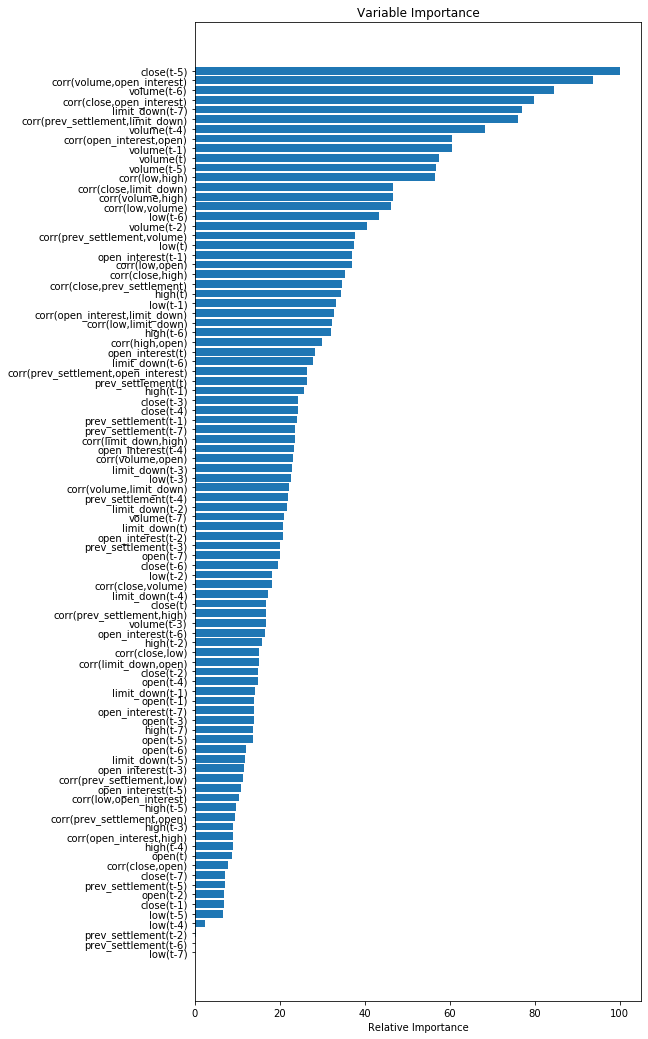

In [159]:
feature_importance = model_linear.feature_importances_
# # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos,x_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [160]:
# 3 day
selected_cols = list(x_train.keys()[sorted_idx][::-1][:30])
selected_cols

['close(t-5)',
 'corr(volume,open_interest)',
 'volume(t-6)',
 'corr(close,open_interest)',
 'limit_down(t-7)',
 'corr(prev_settlement,limit_down)',
 'volume(t-4)',
 'corr(open_interest,open)',
 'volume(t-1)',
 'volume(t)',
 'volume(t-5)',
 'corr(low,high)',
 'corr(close,limit_down)',
 'corr(volume,high)',
 'corr(low,volume)',
 'low(t-6)',
 'volume(t-2)',
 'corr(prev_settlement,volume)',
 'low(t)',
 'open_interest(t-1)',
 'corr(low,open)',
 'corr(close,high)',
 'corr(close,prev_settlement)',
 'high(t)',
 'low(t-1)',
 'corr(open_interest,limit_down)',
 'corr(low,limit_down)',
 'high(t-6)',
 'corr(high,open)',
 'open_interest(t)']

# LSTM training

In [169]:
# 3-day--test : current best model

units = 128
model = Sequential()
model.add(LSTM(units = units, return_sequences = True,
             input_shape = [X_train.shape[1], X_train.shape[2]]))
model.add(Activation('sigmoid'))
model.add(Dense(64))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(LSTM(units = units//2))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer= 'adam')

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, epochs = 20,  
                    validation_split = 0.2, batch_size = 1024, 
                    shuffle = False, callbacks = [early_stop])
print (model.summary())

Train on 43435 samples, validate on 10859 samples
Epoch 1/20
43435/43435 [==============================] - 11s 259us/sample - loss: 0.0278 - val_loss: 0.0032
Epoch 2/20
43435/43435 [==============================] - 4s 97us/sample - loss: 0.0105 - val_loss: 0.0032
Epoch 3/20
43435/43435 [==============================] - 4s 92us/sample - loss: 0.0091 - val_loss: 0.0031
Epoch 4/20
43435/43435 [==============================] - 4s 94us/sample - loss: 0.0086 - val_loss: 0.0031
Epoch 5/20
43435/43435 [==============================] - 4s 98us/sample - loss: 0.0081 - val_loss: 0.0031
Epoch 6/20
43435/43435 [==============================] - 4s 96us/sample - loss: 0.0079 - val_loss: 0.0031
Epoch 7/20
43435/43435 [==============================] - 4s 101us/sample - loss: 0.0077 - val_loss: 0.0031
Epoch 8/20
43435/43435 [==============================] - 4s 97us/sample - loss: 0.0075 - val_loss: 0.0032
Epoch 9/20
43435/43435 [==============================] - 4s 96us/sample - loss: 0.0073 - v

# Performance evaluation

In [171]:
y_test_inverse = scaler_y.inverse_transform(Y_test)
y_train_inverse = scaler_y.inverse_transform(Y_train)

In [172]:
def prediction(model, X):
    prediction = model.predict(X)
    prediction = scaler_y.inverse_transform(prediction.reshape(-1,1))   # reshape (-1,1)
    return prediction

In [173]:
prediction_lstm_test = prediction(model, X_test)
prediction_lstm_train = prediction(model, X_train)

In [174]:
prediction_lstm_test

array([[0.00175069],
       [0.00175656],
       [0.00175136],
       ...,
       [0.00171065],
       [0.001733  ],
       [0.00169088]], dtype=float32)

In [175]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.10f}'.format(mae))
    print('Root Mean Square Error: {:.10f}'.format(rmse))
    print('')   

In [176]:
# 3 day ---- 7 day
evaluate_prediction(prediction_lstm_test, y_test_inverse, 'LSTM-test')
evaluate_prediction(prediction_lstm_train, y_train_inverse, 'LSTM-train')

LSTM-test:
Mean Absolute Error: 0.0123924008
Root Mean Square Error: 0.0176276024

LSTM-train:
Mean Absolute Error: 0.0098477853
Root Mean Square Error: 0.0147029338



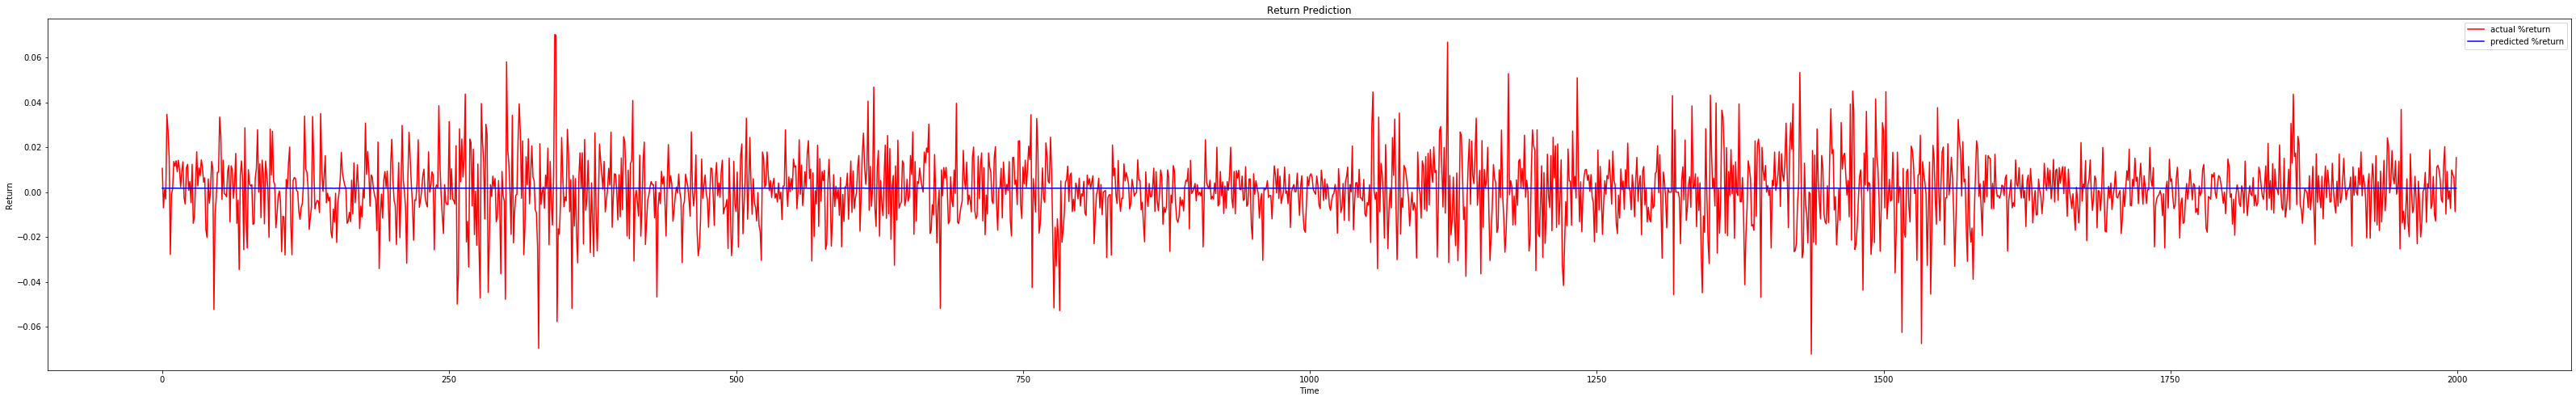

In [177]:
####################################################################################################
# Visualising the results
####################################################################################################
tmp = [i for i in range(len(y_test))]
# final_test.index[:500],
# final_test.index[:500]
plt.figure(figsize=(56,8))
plt.plot(tmp[:2000], y_test[:2000], color = "red", label = "actual %return")
plt.plot(tmp[:2000],prediction_lstm_test.reshape(prediction_lstm_test.shape[0],)[:2000], color = "blue", label = "predicted %return")
# plt.xticks(np.arange(0,459,50))
plt.title('Return Prediction')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()

In [86]:
y_test

array([ 0.06647463, -3.122232  ,  2.057143  , ..., -2.4866421 ,
        0.14752372, -0.7996633 ], dtype=float32)

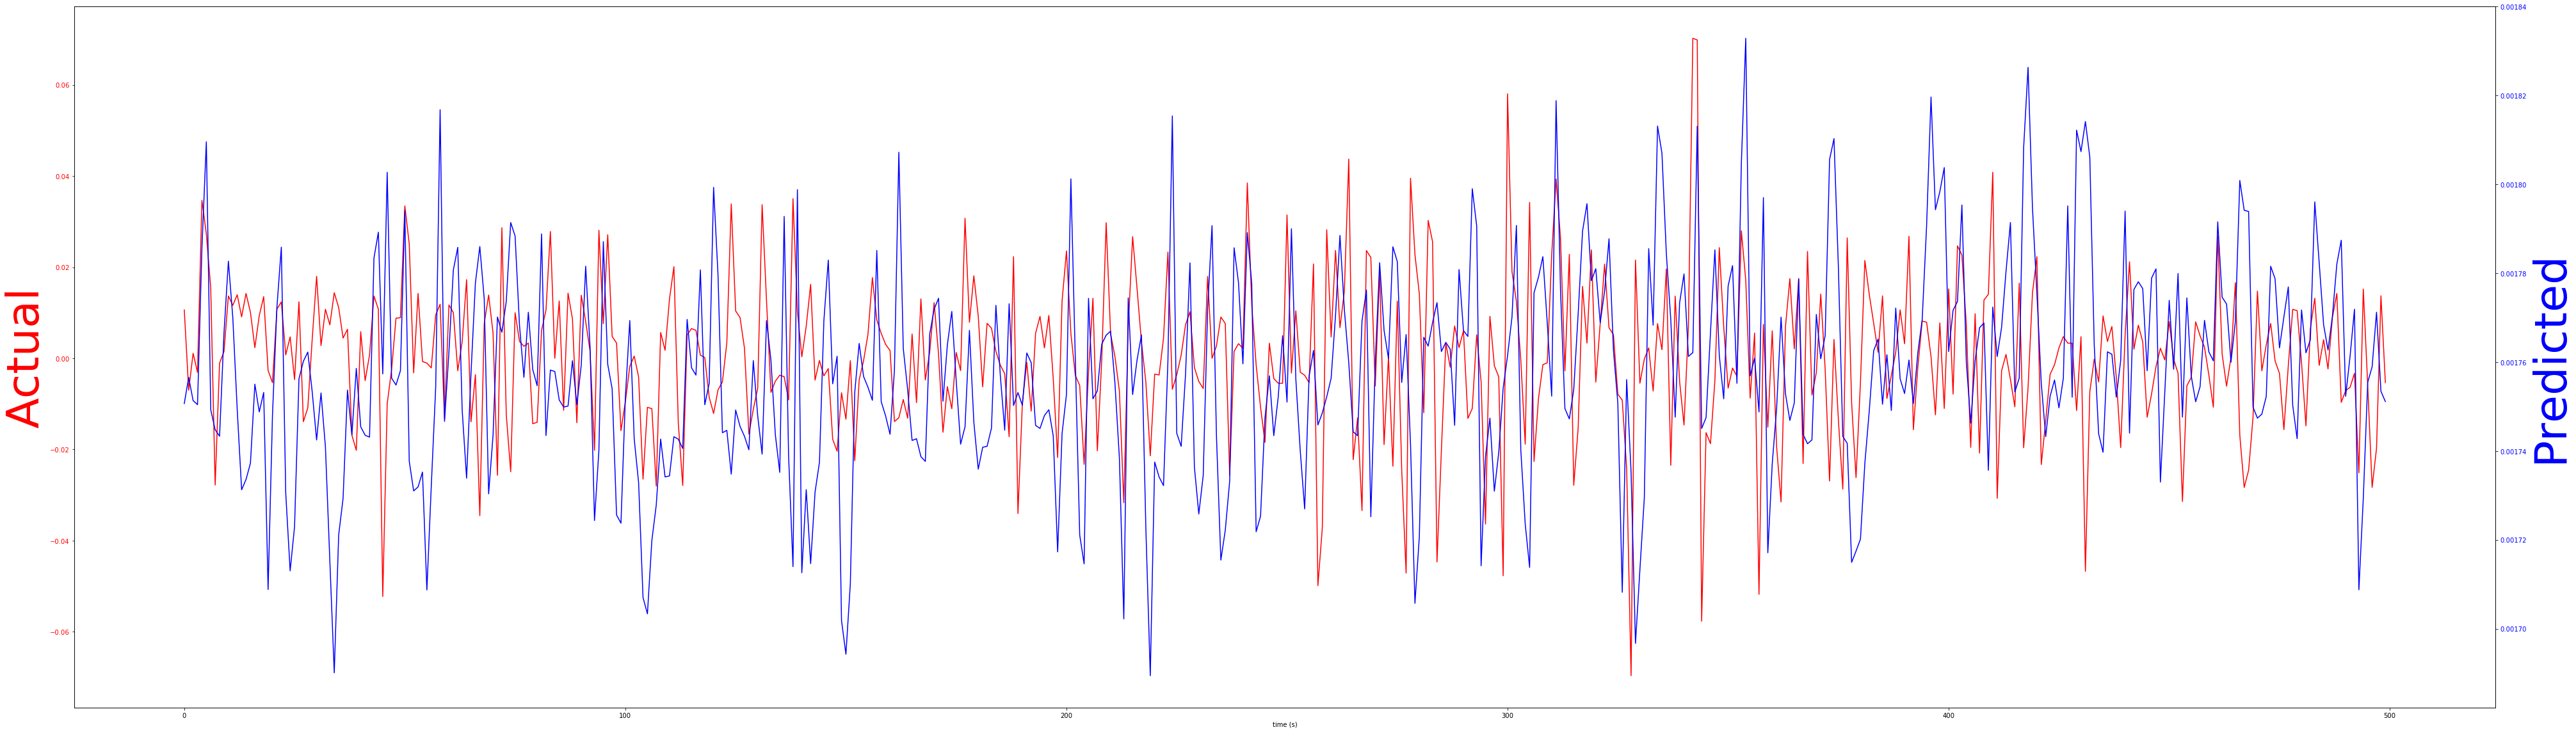

In [178]:
# 7 day
fig, ax1 = plt.subplots(figsize=(56,16))

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Actual', color='red', fontsize=70)
ax1.plot(tmp[:500], y_test[:500], color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  

ax2.set_ylabel('Predicted', color='blue', fontsize=70)  
ax2.plot(tmp[:500], prediction_lstm_test.reshape(prediction_lstm_test.shape[0],)[:500], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout() 
plt.show()

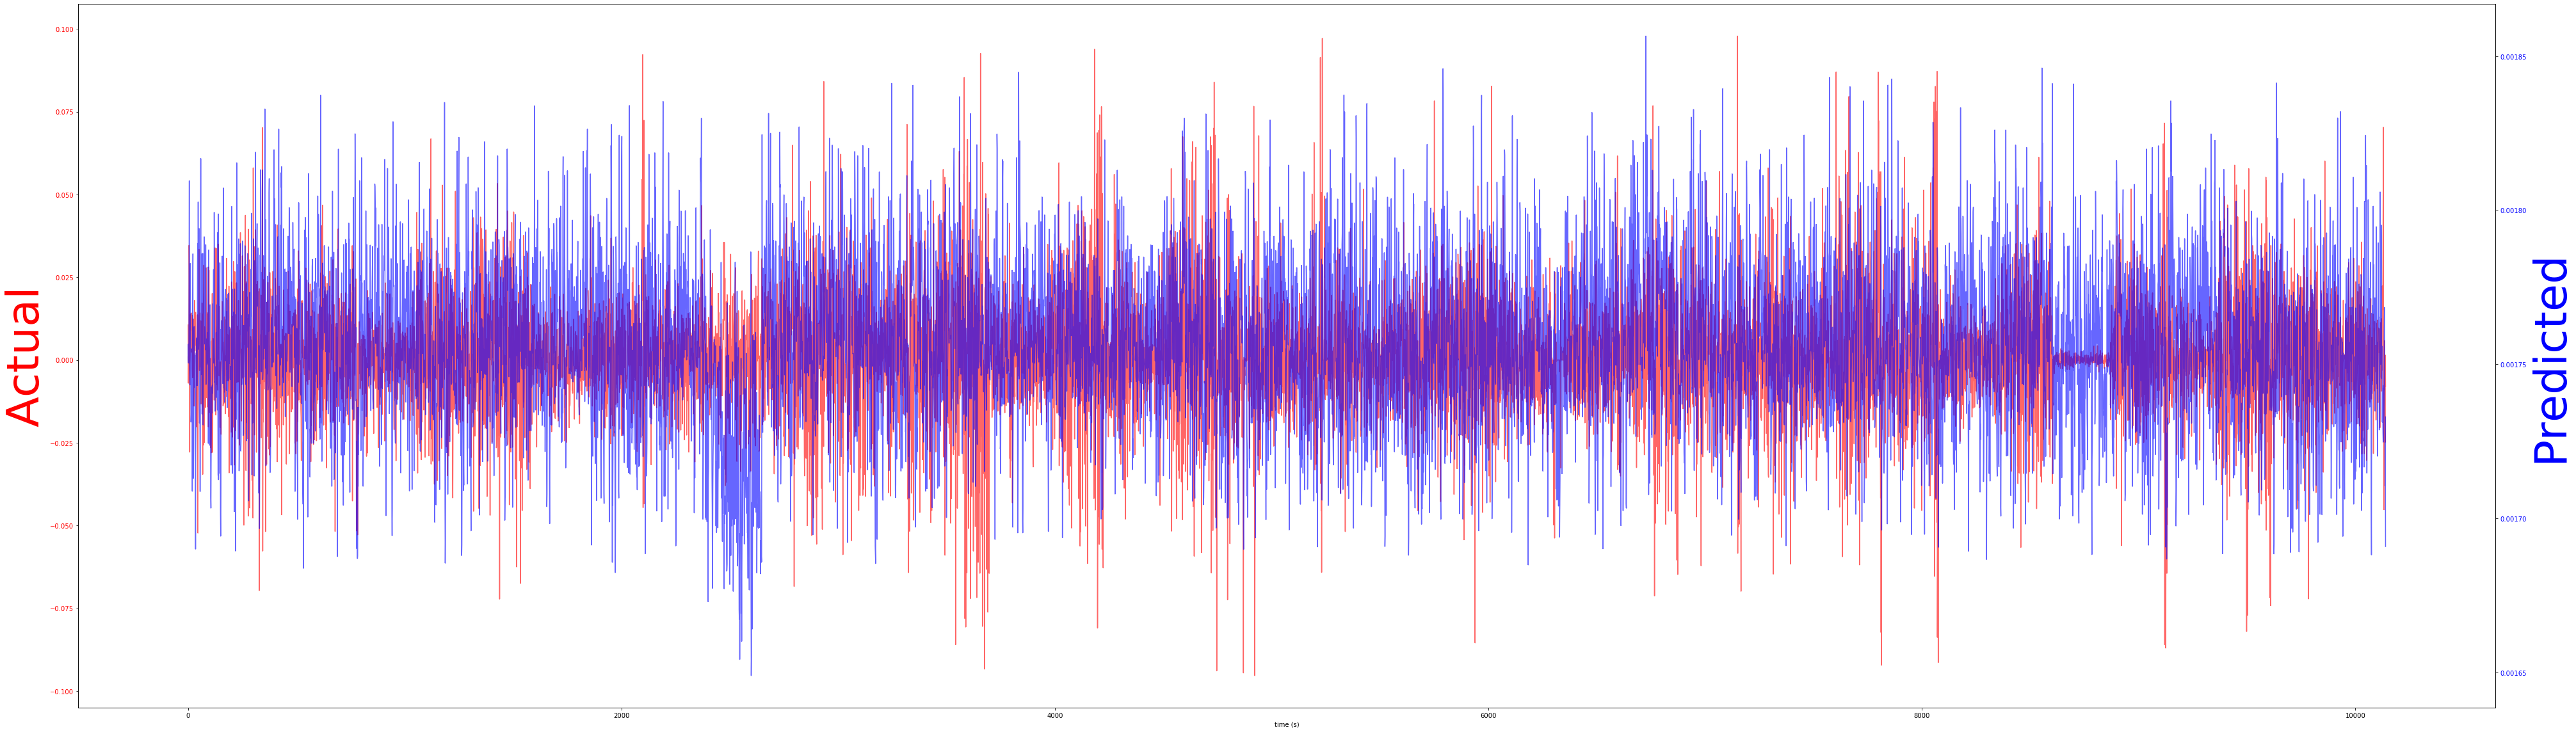

In [180]:
# 7 day 
fig, ax1 = plt.subplots(figsize=(56,16))

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Actual', color='red', fontsize=70)
ax1.plot(tmp, y_test, color='red', alpha = 0.6)
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  

ax2.set_ylabel('Predicted', color='blue', fontsize=70)  
ax2.plot(tmp, prediction_lstm_test.reshape(prediction_lstm_test.shape[0],), color='blue',alpha = 0.6)
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout() 
plt.show()

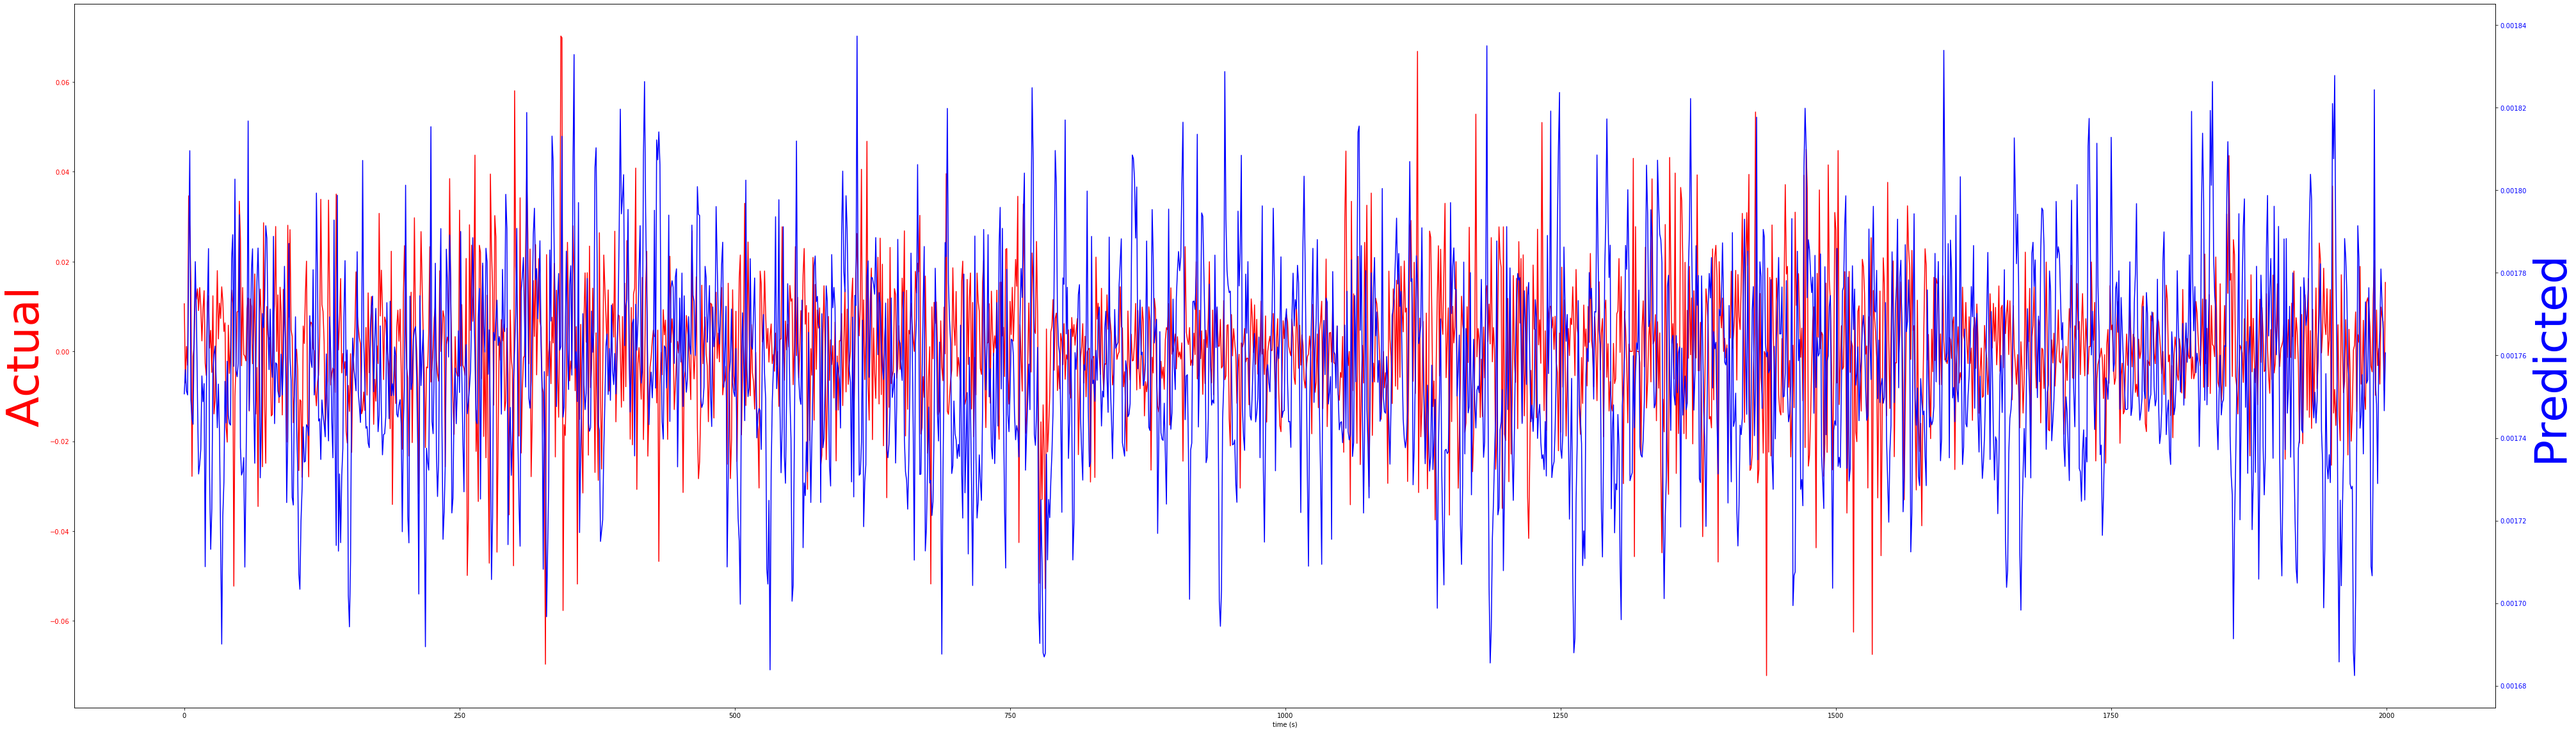

In [181]:
# 3 day, after feature selection, 12.7  batch zize = 1024, mudan parameter
fig, ax1 = plt.subplots(figsize=(56,16))

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Actual', color='red', fontsize=70)
ax1.plot(tmp[:2000], y_test[:2000], color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  

ax2.set_ylabel('Predicted', color='blue', fontsize=70)  
ax2.plot(tmp[:2000], prediction_lstm_test.reshape(prediction_lstm_test.shape[0],)[:2000], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout() 
plt.show()

In [91]:
pred = prediction_lstm_test.reshape(prediction_lstm_test.shape[0],)
print(len(pred))

10144


# ic

In [330]:
# ic graph

In [182]:
pred = prediction_lstm_test.reshape(prediction_lstm_test.shape[0],)
print(len(pred))

10140


In [183]:
ic_df_test = pd.DataFrame({'date': x_test.index.to_list(),
                   'pred': pred,
                   'actual': y_test})
# ic_df = ic_df.set_index('date')

In [184]:
len(train[train['underlying_symbol']=='A'])

1395

In [185]:
len(train['underlying_symbol'].unique())

43

In [186]:
train_pred = prediction_lstm_train.reshape(prediction_lstm_train.shape[0],)
ic_df_train = pd.DataFrame({'date': x_train.index.to_list(),
                   'pred': train_pred,
                   'actual': y_train})

In [187]:
pred

array([0.00175069, 0.00175656, 0.00175136, ..., 0.00171065, 0.001733  ,
       0.00169088], dtype=float32)

In [188]:
y_test

array([ 0.01061008, -0.00699913,  0.00110132, ..., -0.02486642,
        0.00147524, -0.00799663], dtype=float32)

In [189]:
ic_lst_train_1 = []
for date in ic_df_train['date'].unique():
    total_pred =  ic_df_train[ic_df_train['date'] == date]['pred'].to_list()
#     print(total_pred)
    total_act = ic_df_train[ic_df_train['date'] == date]['actual'].to_list()
#     print(total_act)
    ic_lst_train_1.append(my_corrcoef1(total_pred, total_act))
#     print(my_corrcoef1(total_pred, total_act))

In [190]:
ic_lst_test_1 = []
for date in ic_df_test['date'].unique():
    total_pred =  ic_df_test[ic_df_test['date'] == date]['pred'].to_list()
    total_act = ic_df_test[ic_df_test['date'] == date]['actual'].to_list()
    ic_lst_test_1.append(my_corrcoef1(total_pred, total_act))

In [191]:
import copy
ic_lst_train = copy.deepcopy(ic_lst_train_1)
for ind in range(1, len(ic_lst_train)):
    ic_lst_train[ind] = sum(ic_lst_train_1[:ind])

In [192]:
ic_lst_test = copy.deepcopy(ic_lst_test_1)
for ind in range(1, len(ic_lst_test)):
    ic_lst_test[ind] = sum(ic_lst_test_1[:ind])

In [193]:
# 7 day
max(ic_lst_train)

14.82843627052665

In [194]:
sort_ic_train = ic_df_train['date'].unique()
sort_ic_train.sort()

In [195]:
sort_ic_test = ic_df_test['date'].unique()
sort_ic_test.sort()

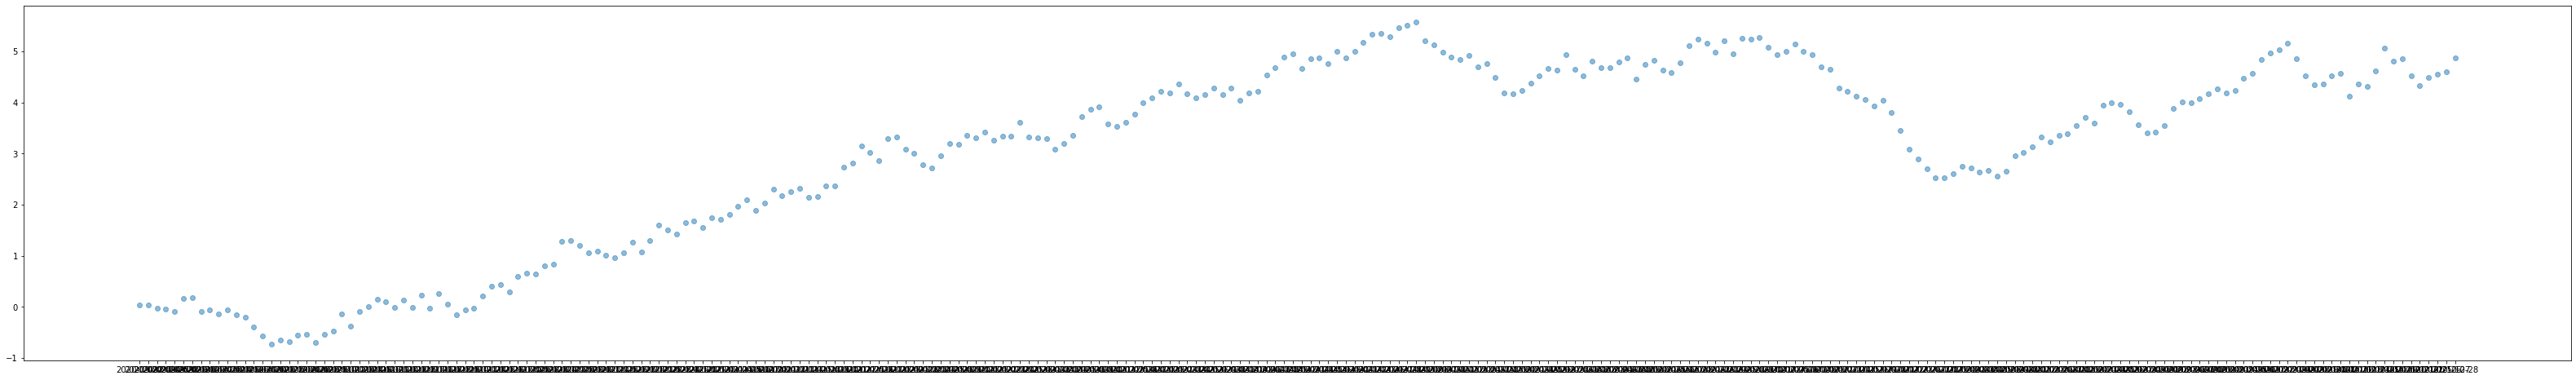

In [196]:
# test ic--7 day
plt.figure(figsize=(56,8))
plt.scatter(sort_ic_test, ic_lst_test, alpha=0.5)
plt.show()

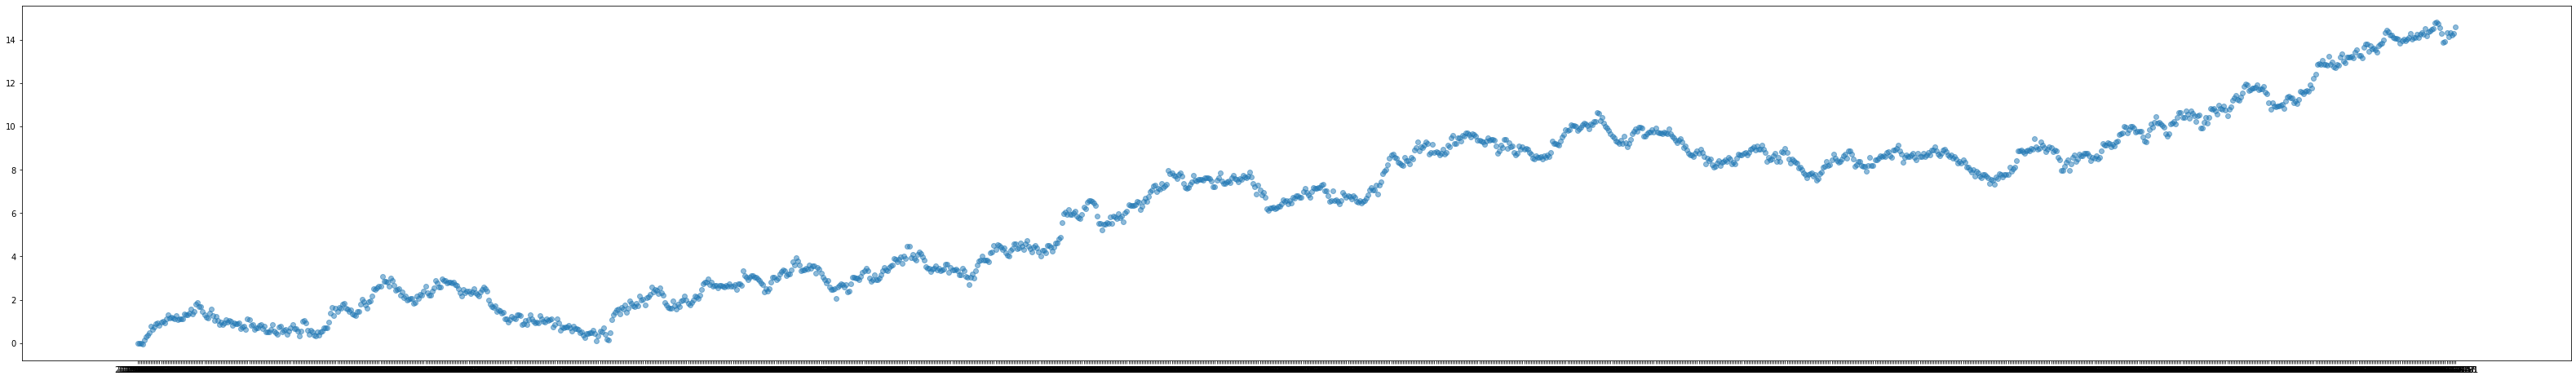

In [197]:
# train ic -- 7 day
plt.figure(figsize=(56,8))
plt.scatter(sort_ic_train, ic_lst_train, alpha=0.5)
plt.show()

In [198]:
ic_lst_total = copy.deepcopy(ic_lst_train)
for ind in range(len(ic_lst_test_1)):
    ic_lst_total.append(ic_lst_total[-1] + ic_lst_test_1[ind])

In [199]:
len(ic_lst_train),len(ic_lst_test)

(1395, 264)

In [200]:
len(ic_lst_total)

1659

In [201]:
total_date= np.array(list(sort_ic_train) + list(sort_ic_test))
month = [date[:7] for date in total_date]

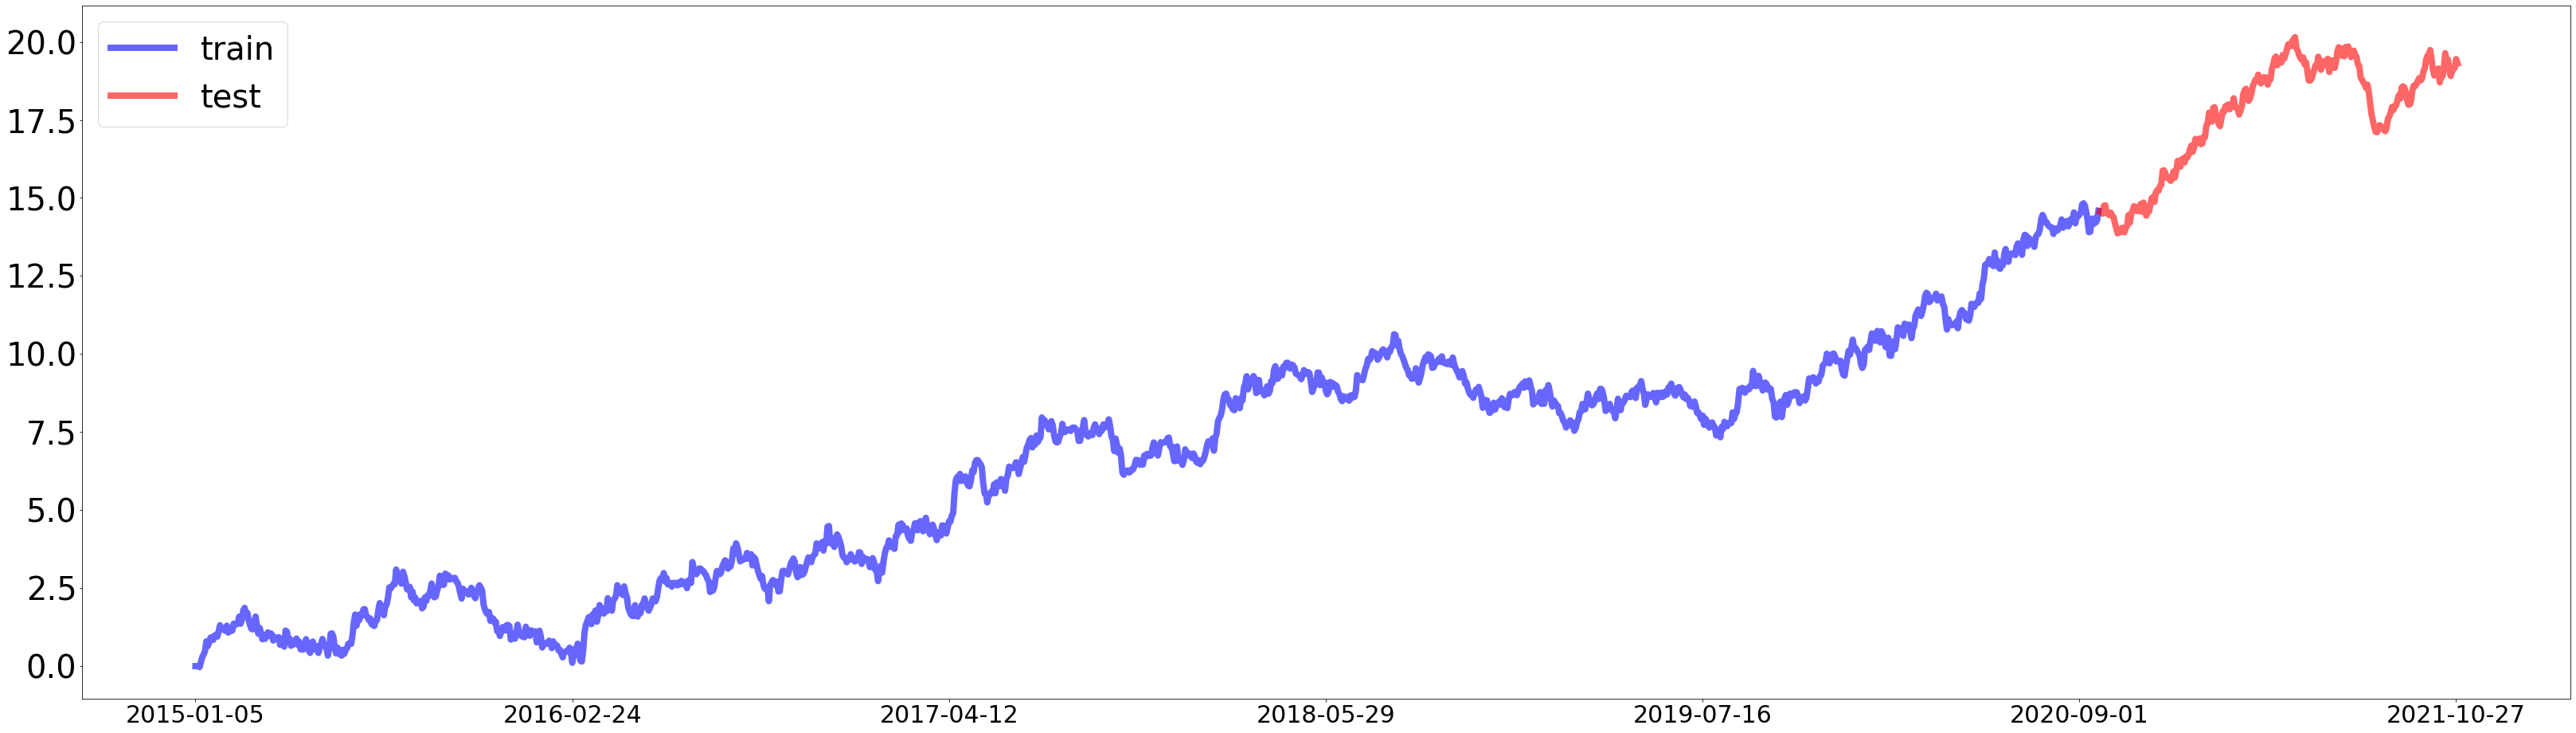

In [202]:
# 7 day
fig, ax = plt.subplots(1, 1, figsize=(56,16))
plt.plot(total_date[:1395], ic_lst_total[:1395], alpha=0.6, color = 'blue', label = 'train',linewidth=8)
plt.plot(total_date[1396:], ic_lst_total[1396:], alpha=0.6, color = 'red', label = 'test',linewidth=8)
plt.legend(loc = 'upper left',fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=30)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) // 6])
plt.show()

In [203]:
# 从test开始corr下降
max(ic_lst_total)

20.156020447512667

In [204]:
min(ic_lst_total)

-0.04316165129597043

In [205]:
max(ic_lst_train)

14.82843627052665

In [206]:
max(ic_lst_test)

5.5703583902456835

# End